In [ ]:
! wget https://github.com/hse-aml/hadron-collider-machine-learning/releases/download/Week_3/check_agreement.csv.gz
! wget https://github.com/hse-aml/hadron-collider-machine-learning/releases/download/Week_3/check_correlation.csv.gz
! wget https://github.com/hse-aml/hadron-collider-machine-learning/releases/download/Week_3/test.csv.gz
! wget https://github.com/hse-aml/hadron-collider-machine-learning/releases/download/Week_3/training.csv.gz

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

from hep_ml import metrics
from utils import check_correlation
from mass_correlation_utils import *

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data Loading
`training.csv` is a mixture of simulated signal, real background.

In [2]:
train_df = pd.read_csv('Data/training.csv.gz', sep=',')

In [3]:
train_df.head()

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
0,18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
1,5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
2,11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
3,15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,...,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
4,1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,...,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060


In [4]:
train_df.columns

Index(['id', 'LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP',
       'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc',
       'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3',
       'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof',
       'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP',
       'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p',
       'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits', 'production',
       'signal', 'mass', 'min_ANNmuon'],
      dtype='object')

In [5]:
train_df.shape

(67553, 51)

In [6]:
test_df = pd.read_csv('Data/test.csv.gz', sep=',', index_col='id')

In [7]:
test_df.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits
id,,,,,,,,,,,,,,,,,,,,,
14711831,0.001273,0.999816,8.569642,0.310039,0.197893,5.183939,2.286117,687.479248,0.022301,0.050763,...,508.926514,306.629456,714.222717,30300.734375,5662.158691,7406.368164,4.779700,3.608334,3.029715,705
16316387,0.000661,0.999954,7.061379,0.348772,0.067430,6.316281,3.865824,5691.845703,0.002455,0.037633,...,943.130676,3287.291260,1563.593994,6160.323730,43781.566406,19728.500000,2.563915,3.280884,3.226650,907
6771382,0.000889,0.999999,6.502967,0.273914,0.011020,0.865816,1.004631,5429.225586,0.002753,0.036379,...,2886.055908,2216.936279,598.068359,26387.134766,15534.978516,6504.145020,2.903129,2.634985,3.077517,213
686045,0.001295,0.999301,7.838184,0.325697,0.388636,11.391245,10.345356,661.717834,0.008163,0.436003,...,461.727753,357.967560,1118.084229,5451.857422,10281.403320,23722.742188,3.160085,4.050494,3.747409,275
8755882,0.001714,0.999805,7.064559,0.113440,0.154421,13.925871,12.951378,3885.417969,0.066317,0.052183,...,1773.747925,1643.278198,711.572205,7724.954590,12830.546875,6008.145996,2.151059,2.744157,2.823017,357


In [8]:
test_df.columns

Index(['LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP',
       'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc',
       'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3',
       'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof',
       'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP',
       'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p',
       'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits'],
      dtype='object')

In [9]:
test_df.shape

(855819, 46)

# Baseline Model

In [10]:
train, valid = train_test_split(train_df, test_size=0.3, random_state=13)

Feature selction for training.

In [11]:
variables = list(set(train_df.columns) - {'id', 'signal', 'mass', 'production', 'min_ANNmuon'})
print(variables)

['IP_p1p2', 'p0_pt', 'p1_pt', 'pt', 'p2_IsoBDT', 'p2_track_Chi2Dof', 'IP_p0p2', 'isolationb', 'p1_p', 'dira', 'isolationa', 'FlightDistanceError', 'iso', 'SPDhits', 'IP', 'CDF3', 'isolatione', 'p0_track_Chi2Dof', 'LifeTime', 'ISO_SumBDT', 'IPSig', 'p2_p', 'isolationf', 'VertexChi2', 'CDF1', 'p0_IsoBDT', 'p0_eta', 'p1_track_Chi2Dof', 'p2_pt', 'DOCAtwo', 'p1_IPSig', 'p2_IPSig', 'p1_eta', 'p2_eta', 'p1_IP', 'DOCAone', 'isolationc', 'isolationd', 'p0_IP', 'p0_IPSig', 'p2_IP', 'p0_p', 'p1_IsoBDT', 'DOCAthree', 'CDF2', 'FlightDistance']


In [12]:
# Data Preprocessing

obj_SC = StandardScaler()
obj_SC.fit(train[variables])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
%%time

clf = AdaBoostClassifier(n_estimators=100, 
                         learning_rate=0.01, 
                         random_state=13,
                         base_estimator=DecisionTreeClassifier(max_depth=6, 
                                                               min_samples_leaf=30, 
                                                               max_features=6,
                                                               random_state=13))
clf.fit(obj_SC.transform(train[variables]), train['signal'])

Wall time: 22.4 s


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=30,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=13, splitter='best'),
          learning_rate=0.01, n_estimators=100, random_state=13)

## Model Assesment on Validation Set


In [14]:
def plot_metrics(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    plt.plot(fpr, tpr, label='ROC AUC=%f' % roc_auc)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.title("ROC Curve")

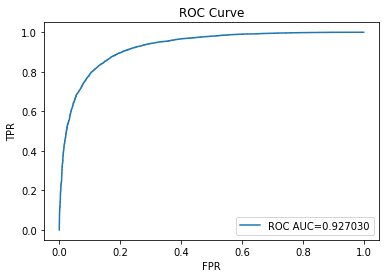

In [15]:
y_pred = clf.predict_proba(obj_SC.transform(valid[variables]))[:, 1]

assert valid.shape[0], y_pred.shape[0]

plot_metrics(valid['signal'], y_pred)

In [16]:
valid.shape

(20266, 51)

In [17]:
y_pred.shape

(20266,)

ROC AUC is just a part of the solution, we also have to make sure that

- The classifier output is not correlated with the mass
- Classifier performs similarily on MC and real data of the normalization channel

### 1. Mass Correlation Check

In [18]:
df_corr_check = pd.read_csv("Data/check_correlation.csv.gz")

In [19]:
df_corr_check.shape

(5514, 48)

In [20]:
y_pred = clf.predict(obj_SC.transform(df_corr_check[variables]))

In [21]:
eff = get_efficiencies(y_pred, 
                       df_corr_check.mass, 
                       thresholds = [0.2, 0.4, 0.5, 0.6, 0.8])

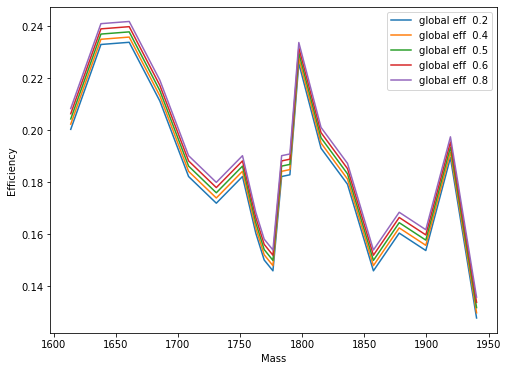

In [22]:
plt.rcParams["figure.figsize"] = 8, 6

up = 1e-3
for label_name, eff_data in eff.items():
    plt.plot(eff_data[0], eff_data[1] + up, label="global eff  %.1f" % label_name)
    up = up + 2e-3

plt.xlabel('Mass')
plt.ylabel('Efficiency')
plt.legend()
plt.show()

In above visualization, y axis is shifted sligthly by 0.002  from previos line just to avoid overlapping.

In [23]:
corr_metric = check_correlation(y_pred, df_corr_check['mass'])
print(corr_metric)

0.00019456333248720528


In [24]:
train[variables][:5]

,IP_p1p2,p0_pt,p1_pt,pt,p2_IsoBDT,p2_track_Chi2Dof,IP_p0p2,isolationb,p1_p,dira,...,isolationc,isolationd,p0_IP,p0_IPSig,p2_IP,p0_p,p1_IsoBDT,DOCAthree,CDF2,FlightDistance
56520,0.062145,778.343079,3227.088623,10099.736328,-0.474115,0.925666,0.061652,0,54594.738281,1.000000,...,1,0.0,0.637930,13.880848,0.147745,12295.371094,-0.381186,0.029572,1.000000,20.195753
13514,0.325892,938.920837,1512.070557,2217.499268,-0.184998,0.725321,0.076166,7,24461.876953,0.999244,...,14,1.0,0.198671,6.079802,0.512594,15100.987305,-0.186370,0.053086,0.870990,5.118261
35888,0.068194,1038.367065,1158.365601,3002.109131,-0.115879,1.477460,0.103214,18,12760.266602,0.999998,...,3,1.0,0.260135,10.005714,0.269683,14818.006836,-0.115879,0.005608,0.328890,10.196308
18577,0.214203,814.597595,2054.098633,3172.664795,-0.115127,0.701390,0.524105,6,57057.406250,0.999973,...,1,1.0,0.158249,3.880044,0.924499,30549.642578,-0.115879,0.192668,0.653669,19.234514
52205,0.392850,546.972168,1355.313721,4432.305176,-0.397122,0.918642,0.465704,0,42211.164062,0.999988,...,0,0.0,1.343604,29.480017,0.336364,14192.293945,-0.343551,0.160036,0.685570,74.620522


### 2. Performace on Simulated Data (MC) vs Read Data

In [25]:
df_agreement = pd.read_csv('Data/check_agreement.csv.gz')

In [26]:
df_agreement.columns

Index(['id', 'LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP',
       'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc',
       'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3',
       'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof',
       'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP',
       'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p',
       'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits', 'signal',
       'weight'],
      dtype='object')

In [27]:
df_agreement[variables].head()

,IP_p1p2,p0_pt,p1_pt,pt,p2_IsoBDT,p2_track_Chi2Dof,IP_p0p2,isolationb,p1_p,dira,...,isolationc,isolationd,p0_IP,p0_IPSig,p2_IP,p0_p,p1_IsoBDT,DOCAthree,CDF2,FlightDistance
0,0.214719,1438.064697,468.645721,2251.611816,-0.098372,1.487057,0.185107,6,6380.673828,0.999964,...,1,2.0,0.483199,24.701061,0.426797,10392.814453,-0.089797,0.066887,0.492269,6.945030
1,0.217507,316.791351,7547.703613,10594.470703,-0.194944,1.336784,0.039357,6,64480.023438,0.999818,...,17,1.0,0.712242,11.312134,0.123877,3174.356934,-0.186370,0.001321,0.605835,9.468235
2,0.885080,1887.477905,317.579529,2502.196289,-0.152291,0.798658,0.335788,2,3921.181641,0.999847,...,1,0.0,0.381544,16.435801,1.290409,15219.761719,-0.131069,0.005850,0.682607,13.280714
3,0.068347,975.041687,1650.837524,5097.813965,-0.434991,0.938619,0.076522,4,13221.149414,0.999998,...,3,0.0,0.564650,24.878387,0.166646,4365.082520,-0.177802,0.003864,0.533615,5.166821
4,0.139937,6035.000977,9657.492188,20388.097656,-0.344313,1.123868,0.249906,1,46903.394531,0.999896,...,0,0.0,0.373736,28.557213,0.112430,27463.011719,-0.443564,0.014612,0.926410,10.897236


In [28]:
def splitted_ROC_curve(data_zero, data_one, sample_weights_zero, sample_weights_one):
    """
    Compute Roc Curve
    
    Input:
    - Data_zero: 0-labeled data
    - Data_one:  1-labeled data
    - Sample_weights_zero: weights for 0-labeled data
    - Sample_weights_one:  weights for 1-labeled data
    
    Output: 
    - roc curve
    """
    
    labels = [0] * len(data_zero) + [1] * len(data_one)
    weights = np.concatenate([sample_weights_zero, sample_weights_one])
    data_all = np.concatenate([data_zero, data_one])
    fpr, tpr, _ = roc_curve(labels, data_all, sample_weight=weights)
    return fpr, tpr

In [29]:
def compute_ks(data_prediction, mc_prediction, weights_data, weights_mc):
    """
    Compute Kolmogorov-Smirnov (ks) distance between real data predictions cdf and Monte Carlo one.
    Input:
    - data_prediction: Real data predictions
    - mc_prediction: Monte Carlo data predictions
    - weights_data: Real data weights
    - weights_mc: Monte Carlo weights
    
    Output
    - ks value
    """
    assert len(data_prediction) == len(weights_data), 'Data length and weight one must be the same'
    assert len(mc_prediction) == len(weights_mc), 'Data length and weight one must be the same'

    data_prediction, mc_prediction = np.array(data_prediction), np.array(mc_prediction)
    weights_data, weights_mc = np.array(weights_data), np.array(weights_mc)

    assert np.all(data_prediction >= 0.) and np.all(data_prediction <= 1.), 'Data predictions are out of range [0, 1]'
    assert np.all(mc_prediction >= 0.) and np.all(mc_prediction <= 1.), 'MC predictions are out of range [0, 1]'

    weights_data /= np.sum(weights_data)
    weights_mc /= np.sum(weights_mc)

    fpr, tpr = splitted_ROC_curve(data_prediction, mc_prediction, weights_data, weights_mc)

    Dnm = np.max(np.abs(fpr - tpr))
    return Dnm

In [30]:
agreement_probs = clf.predict_proba(obj_SC.transform(df_agreement[variables]))[:, 1]

ks = compute_ks(
                agreement_probs[df_agreement['signal'].values == 0],
                agreement_probs[df_agreement['signal'].values == 1],
                df_agreement[df_agreement['signal'] == 0]['weight'].values,
                df_agreement[df_agreement['signal'] == 1]['weight'].values)

print ('KS metric:', ks)
print("KS Metric value is Fine:", ks < 0.09)

KS metric: 0.15680667277623306
KS Metric value is Fine: False


In [31]:
def plot_ks(X_agreement, y_pred):
    sig_ind = X_agreement[X_agreement['signal'] == 1].index
    bck_ind = X_agreement[X_agreement['signal'] == 0].index

    mc_prob = y_pred[sig_ind]
    mc_weight = np.array(X_agreement.loc[sig_ind]['weight'])
    
    data_prob = y_pred[bck_ind]
    data_weight = np.array(X_agreement.loc[bck_ind]['weight'])
    
    inds = data_weight < 0
    mc_weight = np.array(list(mc_weight) + list(-data_weight[inds]))
    mc_prob = np.array(list(mc_prob) + list(data_prob[inds]))
    
    data_prob = data_prob[data_weight >= 0]
    data_weight = data_weight[data_weight >= 0]
    
    plt.hist(data_prob, weights=data_weight, color='r', histtype='step', density=True, bins=60, label='Data')
    plt.hist(mc_prob, weights=mc_weight, color='b', histtype='step', density=True, bins=60, label='MC')
    
    plt.xlabel("Prediction")
    plt.legend()
    plt.show()

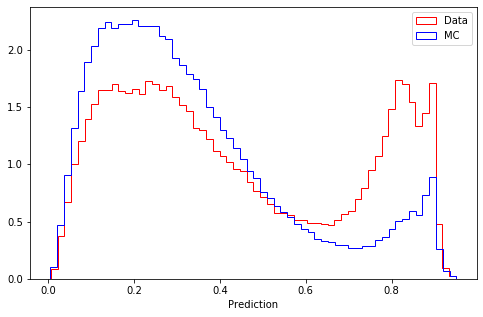

In [32]:
plt.rcParams["figure.figsize"] = 8, 5

plot_ks(df_agreement, agreement_probs)

We can clearly see that that there is no agreemen between the simualted data and the real data.

## Solution 1: Add Random Noise

To increase the agreement between the real data and simualted data, we can add random noise in predicted probabilities.

In [33]:
def add_noise(array, level=0.40, random_seed=34, noise="uniform"):
    np.random.seed(random_seed)
    if noise == "uniform":
        return level * np.random.uniform(size=array.size) + (1 - level) * array
    elif noise == "gaussian":
        return level * np.random.normal(size=array.size) + (1 - level) * array
    elif noise == "laplacian":
        return level * np.random.laplace(size=array.size) + (1 - level) * array
    elif noise == "laplacian":  
        return level * np.random.standard_t(df=1, size=array.size) + (1 - level) * array

In [34]:
agreement_probs_noise = add_noise(clf.predict_proba(df_agreement[variables])[:, 1])

In [35]:
ks_noise = compute_ks(
                        agreement_probs_noise[df_agreement['signal'].values == 0],
                        agreement_probs_noise[df_agreement['signal'].values == 1],
                        df_agreement[df_agreement['signal'] == 0]['weight'].values,
                        df_agreement[df_agreement['signal'] == 1]['weight'].values)

print ('KS metric:', ks_noise)
print("KS Metric value is Fine:", ks_noise < 0.09)

KS metric: 0.014359378165020031
KS Metric value is Fine: True


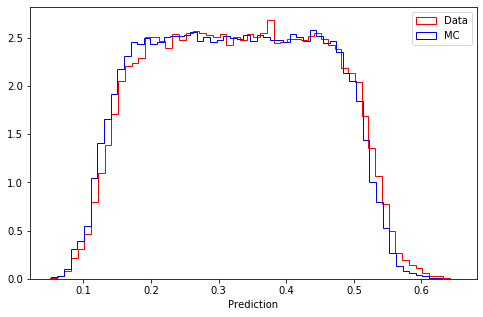

In [36]:
plt.rcParams["figure.figsize"] = 8, 5

plot_ks(df_agreement, agreement_probs_noise)

### Effect on ROC

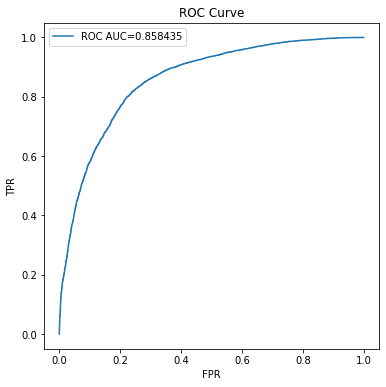

In [37]:
plt.rcParams["figure.figsize"] = 6, 6

y_pred = add_noise(clf.predict_proba(obj_SC.transform(valid[variables]))[:, 1])

assert valid.shape[0] == y_pred.shape[0]

plot_metrics(valid['signal'], y_pred)

We have lost the accuracy of the model by adding noise.

# Gradient Boosted Trees with PCA

This approch could help. There is strong correaltion between some covariates and signal varaiable. Principle compionet Analysis helps uncorrelate data.

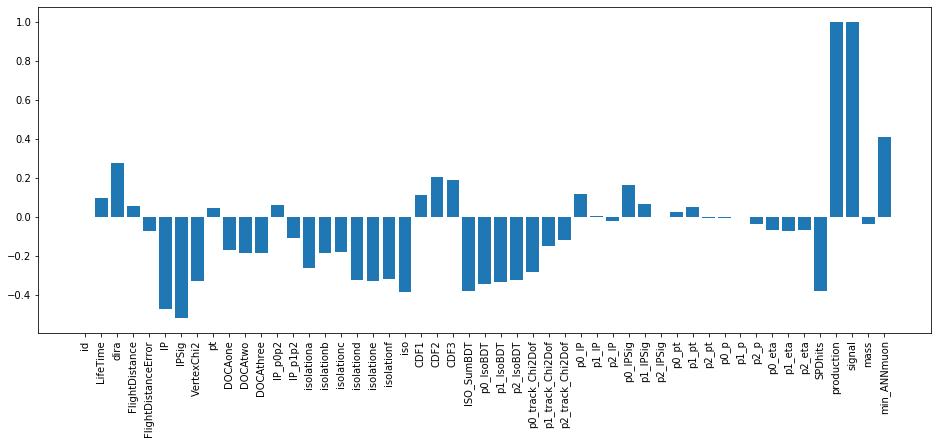

In [38]:
plt.rcParams["figure.figsize"] = 16, 6

plt.bar(train_df.columns, train_df.corr()["signal"])
plt.xticks(rotation='vertical')
plt.show()

Explained Variance Ratio:  0.9999999989738714


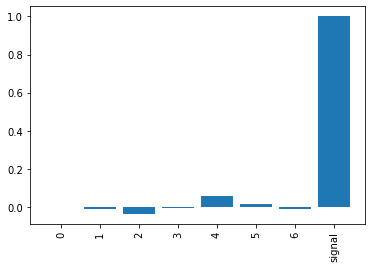

In [39]:
# A PCA model is fitted here just for the visulaization. This will not be used.

plt.rcParams["figure.figsize"] = 6, 4


obj_PCA = PCA(n_components=7, random_state=13)
obj_PCA.fit(train_df)

print("Explained Variance Ratio: ", obj_PCA.explained_variance_ratio_.sum())

temp = pd.DataFrame(obj_PCA.transform(train_df))
temp["signal"] = train_df["signal"]

plt.bar([str(x) for x in temp.columns], temp.corr()["signal"])
plt.xticks(rotation='vertical')
plt.show()

del obj_PCA, temp

We can see here that the correaltion is dropped very much as compared to previous plot. The column names are changes because data is decomposed into the priniple componenet vectors which are projects of components of data in different dimesnions which are mutually normal to each other.

In [40]:
obj_PCA = PCA(n_components=40, random_state=13)
obj_PCA.fit(obj_SC.transform(train[variables]))

print("Explained Variance Ratio: ", obj_PCA.explained_variance_ratio_.sum())

Explained Variance Ratio:  0.9961446579442471


In [41]:
%%time

clf_1 = AdaBoostClassifier(n_estimators=100, 
                         learning_rate=0.01, 
                         random_state=13,
                         base_estimator=DecisionTreeClassifier(max_depth=6, 
                                                               min_samples_leaf=30, 
                                                               max_features=6,
                                                               random_state=13))

clf_1.fit(obj_PCA.transform(obj_SC.transform(train[variables])), train['signal'])

Wall time: 30.7 s


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=30,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=13, splitter='best'),
          learning_rate=0.01, n_estimators=100, random_state=13)

In [42]:
agreement_probs_pca = clf_1.predict_proba(obj_PCA.transform(obj_SC.transform(df_agreement[variables])))[:, 1]

In [43]:
ks_noise = compute_ks(
                        agreement_probs_pca[df_agreement['signal'].values == 0],
                        agreement_probs_pca[df_agreement['signal'].values == 1],
                        df_agreement[df_agreement['signal'] == 0]['weight'].values,
                        df_agreement[df_agreement['signal'] == 1]['weight'].values)

print ('KS metric:', ks_noise)
print("KS Metric value is Fine:", ks_noise < 0.09)

KS metric: 0.09637934904176032
KS Metric value is Fine: False


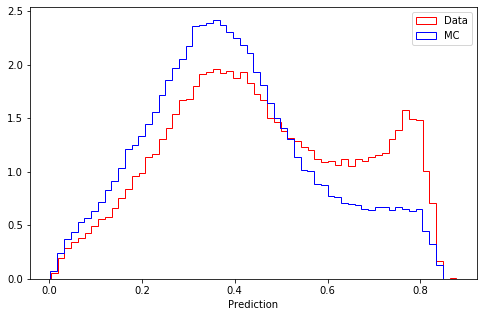

In [44]:
plt.rcParams["figure.figsize"] = 8, 5

plot_ks(df_agreement, agreement_probs_pca)

The agreemnt between the simualted data and the real data improved as compared to the baseline model.

### Effect on ROC

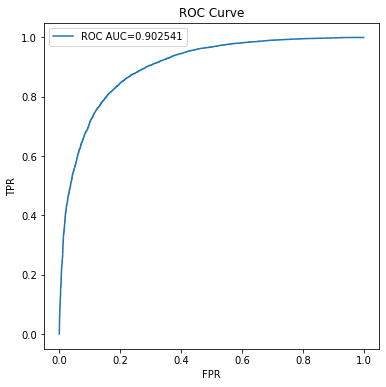

In [45]:
plt.rcParams["figure.figsize"] = 6, 6

y_pred = clf_1.predict_proba(obj_PCA.transform(obj_SC.transform(valid[variables])))[:, 1]

assert valid.shape[0] == y_pred.shape[0]

plot_metrics(valid['signal'], y_pred)

Also I am able to retain the AUC metric wuth decrese from 92.xxxx to 90.xxxx

# Neural Networks with Mass Reconstruction

In [107]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.utils.vis_utils import plot_model

In [108]:
from keras import backend as K

def r_sqaured_error(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [284]:
def NN(input_dim, weight=[1.0, 1.0]):
    shared = Sequential()
    shared.add(Dense(100, activation="relu", name="Hidden_1"))
    shared.add(Dense(80, activation="relu", name="Hidden_2"))
    shared.add(Dense(60, activation="relu", name="Hidden_3"))


    data = Input(shape=(input_dim, ), name="Input_Layer")
    features = shared(data)

    signal = Dense(1, activation='sigmoid', name='Signal', kernel_initializer="glorot_normal")(features)
    mass   = Dense(1, activation='linear', name='Mass', kernel_initializer="glorot_normal")(features)

    model =  Model(inputs=[data], outputs=[signal, mass])
    model.compile(optimizer = 'Adam', 
                  loss = ['binary_crossentropy', "mean_squared_error"],
                  loss_weights = weight)
    
    return model

In [302]:
model = NN(len(variables), weight=[1, .75])
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [303]:
obj_SC_mass = StandardScaler()
obj_SC_mass.fit(train["mass"].values.reshape(-1, 1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [304]:
model.fit(x = [obj_SC.transform(train[variables])], 
          y = [train["signal"], obj_SC_mass.transform([train["mass"]])[0]],
          batch_size = 5000, 
          epochs = 100,
          validation_split = 0.1)

Train on 42558 samples, validate on 4729 samples
Epoch 1/100
42558/42558 [==============================] - 1s 33us/step - loss: 1.3576 - Signal_loss: 0.5928 - Mass_loss: 1.0198 - val_loss: 1.2335 - val_Signal_loss: 0.4860 - val_Mass_loss: 0.9967
Epoch 2/100
42558/42558 [==============================] - 0s 6us/step - loss: 1.1969 - Signal_loss: 0.4421 - Mass_loss: 1.0065 - val_loss: 1.1382 - val_Signal_loss: 0.3939 - val_Mass_loss: 0.9924
Epoch 3/100
42558/42558 [==============================] - 0s 6us/step - loss: 1.1287 - Signal_loss: 0.3793 - Mass_loss: 0.9992 - val_loss: 1.1044 - val_Signal_loss: 0.3610 - val_Mass_loss: 0.9912
Epoch 4/100
42558/42558 [==============================] - 0s 6us/step - loss: 1.0955 - Signal_loss: 0.3507 - Mass_loss: 0.9930 - val_loss: 1.0823 - val_Signal_loss: 0.3420 - val_Mass_loss: 0.9871
Epoch 5/100
42558/42558 [==============================] - 0s 6us/step - loss: 1.0743 - Signal_loss: 0.3335 - Mass_loss: 0.9878 - val_loss: 1.0641 - val_Signal_lo

42558/42558 [==============================] - 0s 6us/step - loss: 0.7085 - Signal_loss: 0.2535 - Mass_loss: 0.6067 - val_loss: 0.8436 - val_Signal_loss: 0.2708 - val_Mass_loss: 0.7637
Epoch 43/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.6998 - Signal_loss: 0.2534 - Mass_loss: 0.5952 - val_loss: 0.8489 - val_Signal_loss: 0.2714 - val_Mass_loss: 0.7701
Epoch 44/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.6976 - Signal_loss: 0.2531 - Mass_loss: 0.5926 - val_loss: 0.8465 - val_Signal_loss: 0.2717 - val_Mass_loss: 0.7665
Epoch 45/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.6939 - Signal_loss: 0.2530 - Mass_loss: 0.5879 - val_loss: 0.8323 - val_Signal_loss: 0.2713 - val_Mass_loss: 0.7481
Epoch 46/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.6836 - Signal_loss: 0.2530 - Mass_loss: 0.5742 - val_loss: 0.8319 - val_Signal_loss: 0.2714 - val_Mass_loss: 0.7474
Epoch 47/100
42558/4255

42558/42558 [==============================] - 0s 7us/step - loss: 0.5376 - Signal_loss: 0.2427 - Mass_loss: 0.3933 - val_loss: 0.7398 - val_Signal_loss: 0.2668 - val_Mass_loss: 0.6306
Epoch 84/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.5296 - Signal_loss: 0.2421 - Mass_loss: 0.3833 - val_loss: 0.7326 - val_Signal_loss: 0.2669 - val_Mass_loss: 0.6209
Epoch 85/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.5260 - Signal_loss: 0.2420 - Mass_loss: 0.3787 - val_loss: 0.7288 - val_Signal_loss: 0.2662 - val_Mass_loss: 0.6168
Epoch 86/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.5243 - Signal_loss: 0.2416 - Mass_loss: 0.3770 - val_loss: 0.7269 - val_Signal_loss: 0.2666 - val_Mass_loss: 0.6136
Epoch 87/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.5194 - Signal_loss: 0.2414 - Mass_loss: 0.3707 - val_loss: 0.7308 - val_Signal_loss: 0.2665 - val_Mass_loss: 0.6190
Epoch 88/100
42558/4255

In [305]:
def get_prob(low, high, df, method = "direct"):
    prediction, temp =  model.predict(obj_SC.transform(df[variables]))
    if method == "indirect":
        temp = obj_SC_mass.inverse_transform(temp)
        plt.hist(temp, bins=50)
        plt.show()
        res_idx = np.logical_and(temp > low , temp < high)[:,0]
        probs = np.zeros((df.shape[0]))
        probs[res_idx] = 1
        return probs
    elif method == "direct":
        return prediction
    else:
        temp = obj_SC_mass.inverse_transform(temp)
        res_idx = np.logical_and(temp > low , temp < high)[:,0]
        probs = np.zeros((df.shape[0]))
        probs[res_idx] = 1
        return (probs + prediction)/2

In [306]:
low = 1640
high = 2000
mtd = "direct"

In [307]:
agreement_probs_mass = get_prob(low, high, df_agreement, mtd)

In [308]:
ks_noise = compute_ks(
                        agreement_probs_mass[df_agreement['signal'].values == 0],
                        agreement_probs_mass[df_agreement['signal'].values == 1],
                        df_agreement[df_agreement['signal'] == 0]['weight'].values,
                        df_agreement[df_agreement['signal'] == 1]['weight'].values)

print ('KS metric:', ks_noise)
print("KS Metric value is Fine:", ks_noise < 0.09)

KS metric: 0.2386101959229388
KS Metric value is Fine: False


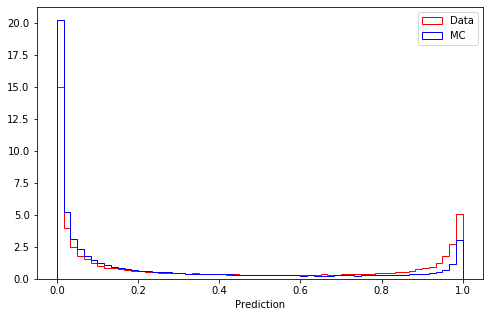

In [309]:
plt.rcParams["figure.figsize"] = 8, 5

plot_ks(df_agreement, agreement_probs_mass)

### Effect on ROC

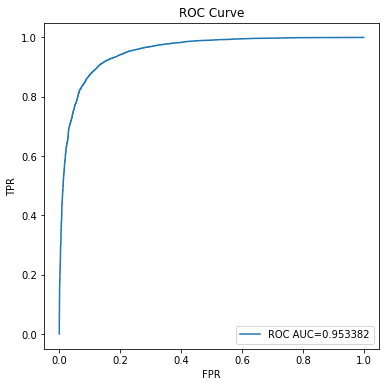

In [310]:
plt.rcParams["figure.figsize"] = 6, 6

y_pred = get_prob(low, high, valid, mtd)

assert valid.shape[0] == y_pred.shape[0]

plot_metrics(valid['signal'], y_pred)